In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

from settings import Config
from mysql_db import Database
import pdcast as pdc
import s3_upload_download as s3con
import os
from datetime import datetime

In [2]:
# for the graphs
sns.set_style('darkgrid')
sns.color_palette('deep')

plt.rc('axes', titlesize=18) 
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=13)    
plt.rc('ytick', labelsize=13)    
plt.rc('legend', fontsize=13)    
plt.rc('font', size=13)     

#pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = 'matplotlib'

# NOTEBOOK DESCRIPTION: 

Explore the relationship between the target variables and the predictors. In particular:

1. Claim Frequency vs. Power and Age, for the personal cars PF and PJ tables;
2. Claim Severity vs. Power and Age, for the personal cars PF and PJ tables;


In [3]:
# initialise the s3_connector object needed to read/write files into an S3 bucket
s3con = s3con.s3_connector()

In [4]:
# load tables
cars_pf = s3con.read('autoturisme_pf.feather')
cars_pj = s3con.read('autoturisme_pj.feather')

sev = s3con.read('claims_vals.feather')
freq = s3con.read('events_no.feather')
exposures = s3con.read('exposures_com.feather')

In [5]:
# first, from sev an freq select only those belonging to personal cars
sev_pf = sev[sev.idPolita.isin(cars_pf.idPolita.values)].copy()
sev_pj = sev[sev.idPolita.isin(cars_pj.idPolita.values)].copy()

freq_pf = freq[freq.idPolita.isin(cars_pf.idPolita.values)].copy()
freq_pj = freq[freq.idPolita.isin(cars_pj.idPolita.values)].copy()

exp_pf = exposures[exposures.idPolita.isin(cars_pf.idPolita.values)].copy()
exp_pj = exposures[exposures.idPolita.isin(cars_pj.idPolita.values)].copy()

del sev, freq, exposures

In [6]:
# next, group the severity table by policy ID to sum up all events belonging to the same policy
policy_claims_pf = sev_pf.groupby('idPolita')['total_val'].sum().to_frame()
policy_claims_pf.reset_index(inplace = True)

policy_claims_pj = sev_pj.groupby('idPolita')['total_val'].sum().to_frame()
policy_claims_pj.reset_index(inplace = True)

del sev_pf, sev_pj

In [7]:
exp_pf.columns

Index(['idPolita', 'dataStart', 'dataEnd', 'maturity', 'exp_2015', 'exp_2016',
       'exp_2017', 'exp_2018', 'exp_2019', 'exp_2020', 'exp_2021'],
      dtype='object')

In [8]:
# add the claims values and total accident number to the attribute tables
merged_pf = cars_pf.merge(policy_claims_pf, on = 'idPolita', how = 'left')
merged_pf = merged_pf.merge(freq_pf[['idPolita', 'total_ev']], on = 'idPolita', how = 'left')
merged_pf = merged_pf.merge(exp_pf[['idPolita','exp_2015', 'exp_2016', 'exp_2017', 'exp_2018', 'exp_2019', 
                                    'exp_2020', 'exp_2021',]], on = 'idPolita', how = 'left')

merged_pj = cars_pj.merge(policy_claims_pj, on = 'idPolita', how = 'left')
merged_pj = merged_pj.merge(freq_pj[['idPolita', 'total_ev']], on = 'idPolita', how = 'left')
merged_pj = merged_pj.merge(exp_pj[['idPolita','exp_2015', 'exp_2016', 'exp_2017', 'exp_2018', 'exp_2019', 
                                    'exp_2020', 'exp_2021',]], on = 'idPolita', how = 'left')

del cars_pf, cars_pj, policy_claims_pf, policy_claims_pj, freq_pf, freq_pj, exp_pf, exp_pj

In [9]:
# create extra column with the total exposure for each policy
pd.eval("total_exp = merged_pf.exp_2015 + merged_pf.exp_2016 + merged_pf.exp_2017 + merged_pf.exp_2018 + merged_pf.exp_2019 + merged_pf.exp_2020 + merged_pf.exp_2021", target = merged_pf, inplace = True)
pd.eval("total_exp = merged_pj.exp_2015 + merged_pj.exp_2016 + merged_pj.exp_2017 + merged_pj.exp_2018 + merged_pj.exp_2019 + merged_pj.exp_2020 + merged_pj.exp_2021", target = merged_pj, inplace = True)

In [10]:
# the merge will generate null values and most policies do not have claims
merged_pf.isnull().sum()

idPolita             0
capacitate           0
varsta               0
total_val     19293319
total_ev      19283500
exp_2015             0
exp_2016             0
exp_2017             0
exp_2018             0
exp_2019             0
exp_2020             0
exp_2021             0
total_exp            0
dtype: int64

In [11]:
merged_pj.isnull().sum()

idPolita            0
capacitate          0
total_val     1964827
total_ev      1964085
exp_2015            0
exp_2016            0
exp_2017            0
exp_2018            0
exp_2019            0
exp_2020            0
exp_2021            0
total_exp           0
dtype: int64

NOTE: for both the PF and PJ, the frequency column does not have an equal number of values as the severity column. This should be investigated.

In [12]:
# for the purposes of this notebook, I will replace the nans with 0s
merged_pf = merged_pf.fillna(0)
merged_pj = merged_pj.fillna(0)

## Frequency analysis

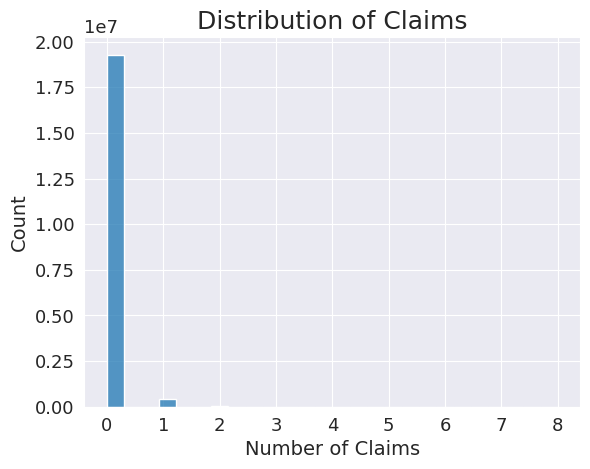

In [13]:
# look at the distribution of claims
sns.histplot(merged_pf.total_ev)
plt.xlabel('Number of Claims')
plt.ylabel('Count')
plt.title('Distribution of Claims');

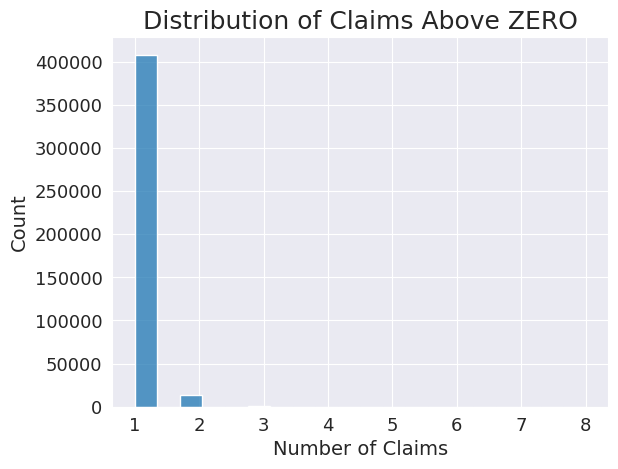

In [14]:
# as the vast majority of policies have no claims, I will redo the distribution without those with no claims
sns.histplot(merged_pf.query("total_ev > 0").total_ev)
plt.xlabel('Number of Claims')
plt.ylabel('Count')
plt.title('Distribution of Claims Above ZERO');

In [15]:
# bin age into multiple categories
bins = [merged_pf.varsta.min(), 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, merged_pf.varsta.max()]
labels = ['<=25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '>75']
merged_pf['age_cat'] = pd.cut(x = merged_pf.varsta, bins = bins, labels = labels, include_lowest = True)

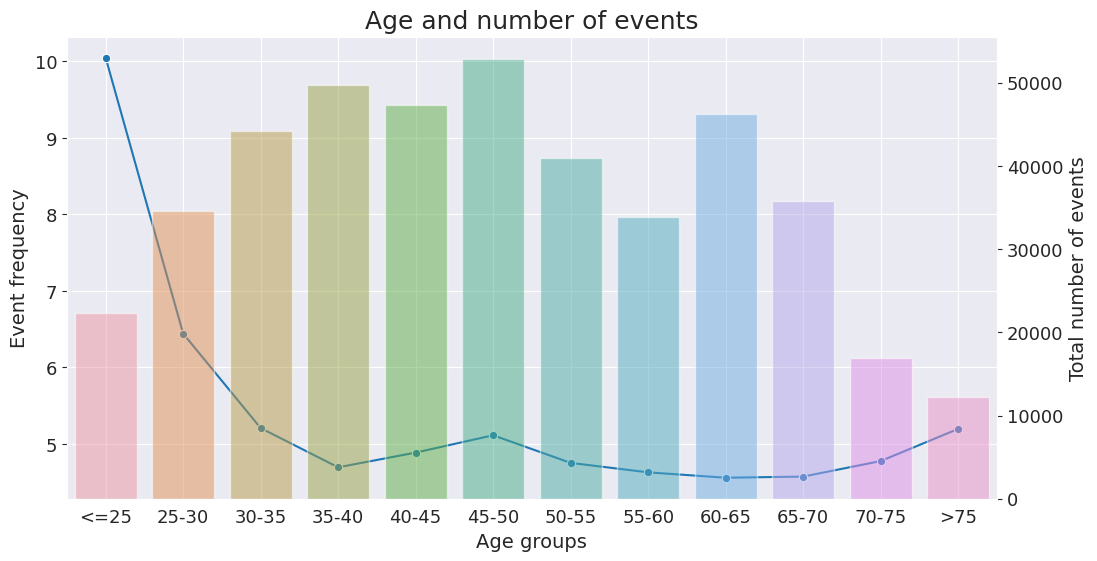

In [16]:
# plot the effect of age on the number of events

ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

# for the lineplot, the events of each group category get summed up and divided by the sum of all exposures from that age group
sns.lineplot(data = [(merged_pf[merged_pf.age_cat == x].total_ev.sum()/merged_pf[merged_pf.age_cat == x].total_exp.sum())*100
                    for x in ['<=25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', 
                    '70-75', '>75']], marker='o',  ax = ax1, sort = False)
ax2 = ax1.twinx()

sns.barplot(data = merged_pf, x='age_cat', y='total_ev', estimator = 'sum', errorbar = None, alpha=0.5, ax = ax2)
ax2.grid(False)

ax1.set(ylabel='Event frequency', xlabel='Age groups', title = 'Age and number of events')
ax2.set(ylabel = 'Total number of events');

In [17]:
# bin cylinder capacity into multiple categories
bins = [merged_pf.capacitate.min(), 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 3500, 4000, 4500, merged_pf.capacitate.max()]
labels = ['<=1000', '1001-1200', '1201-1400', '1401-1600', '1601-1800', '1801-2000', '2001-2500', '2501-3000',
          '3001-3500', '3501-4000', '4001-4500', '>4500']
merged_pf['cap_cat'] = pd.cut(x = merged_pf.capacitate, bins = bins, labels = labels, include_lowest = True)

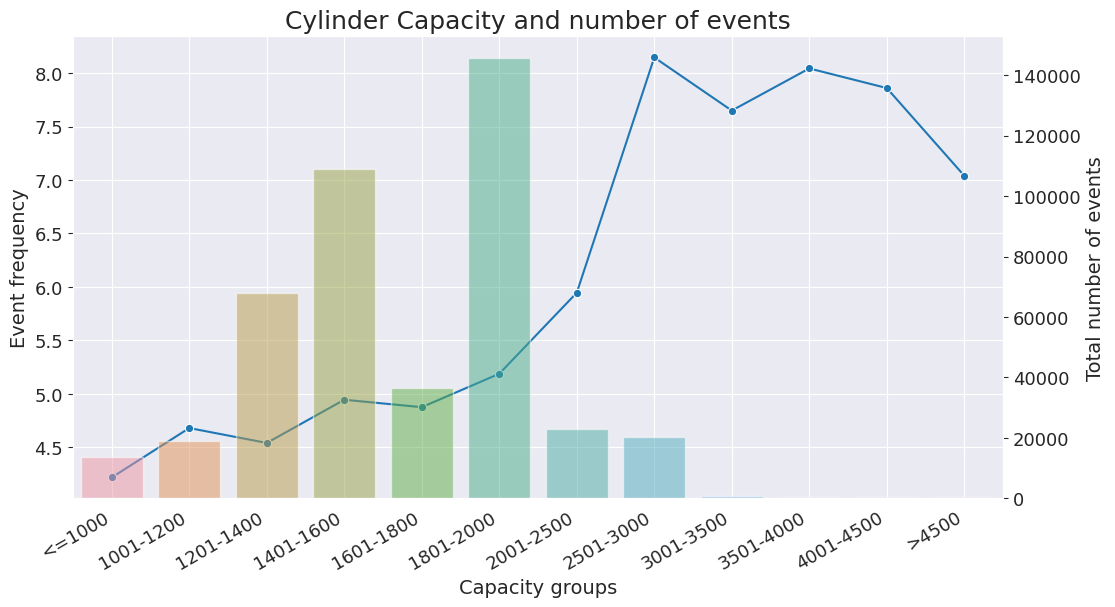

In [18]:
# plot the effect of cylinder capacity on the number of events

ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

# for the lineplot, the events of each group category get summed up and divided by the sum of all exposures from that age group
sns.lineplot(data = [(merged_pf[merged_pf.cap_cat == x].total_ev.sum()/merged_pf[merged_pf.cap_cat == x].total_exp.sum())*100
                    for x in ['<=1000', '1001-1200', '1201-1400', '1401-1600', '1601-1800', '1801-2000', '2001-2500', 
                    '2501-3000', '3001-3500', '3501-4000', '4001-4500', '>4500']], marker='o',  ax = ax1, sort = False)
ax2 = ax1.twinx()

sns.barplot(data = merged_pf, x='cap_cat', y='total_ev', estimator = 'sum', errorbar = None, alpha=0.5, ax = ax2)
ax2.grid(False)

ax1.set(ylabel='Event frequency', xlabel='Capacity groups', title = 'Cylinder Capacity and number of events')
ax2.set(ylabel = 'Total number of events')

plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right');

/tmp/ipykernel_3391/3848278372.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['<=1000', '1001-1200', '1201-1400', '1401-1600', '1601-1800', '1801-2000', '2001-2500',


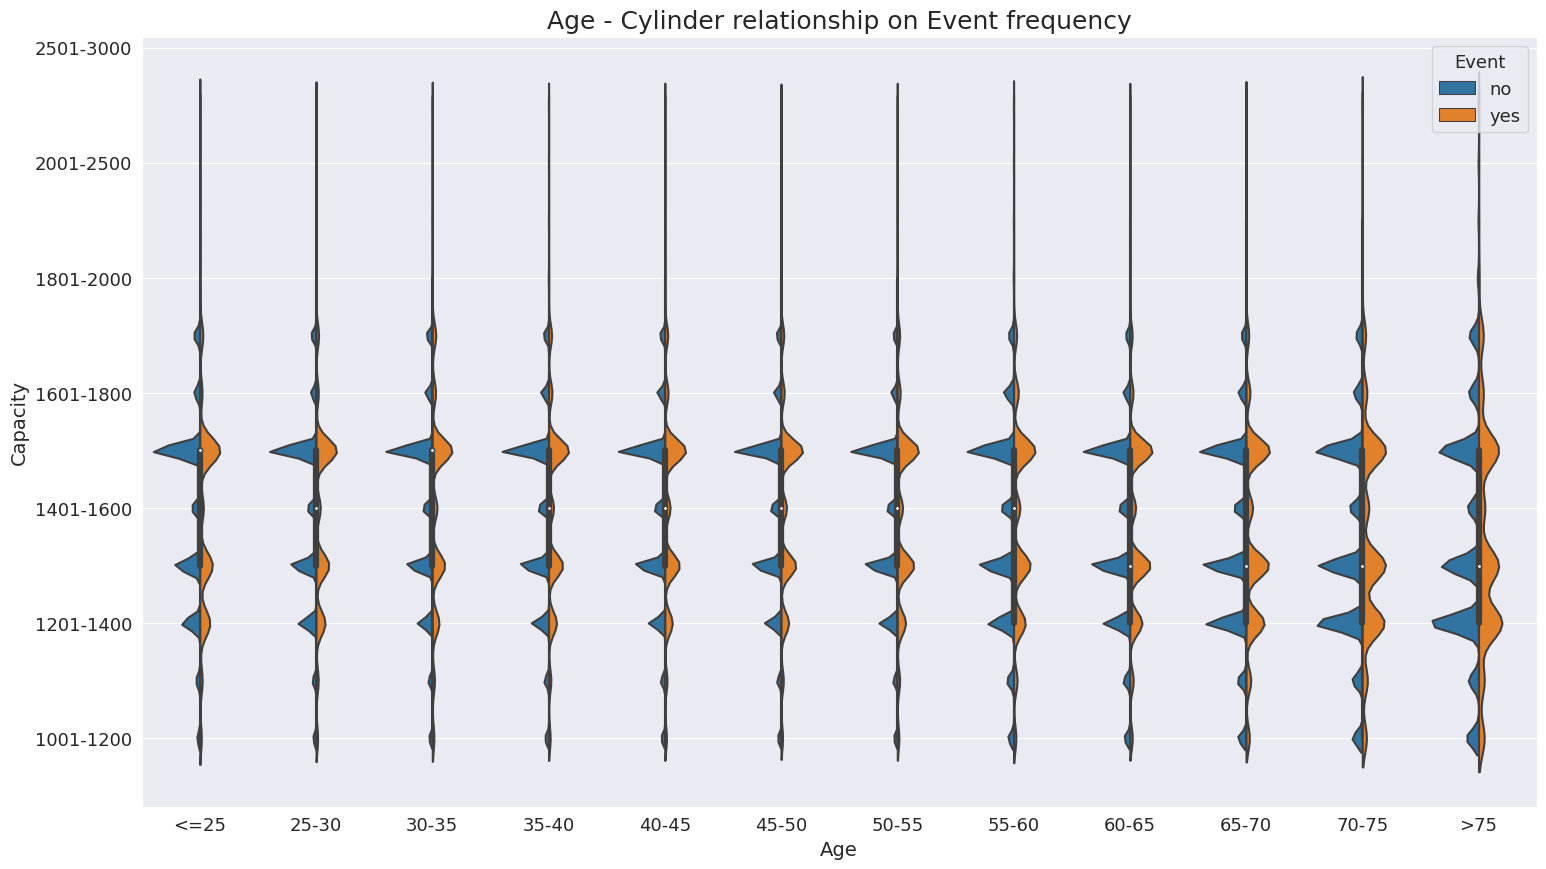

In [19]:
merged_pf['Event'] = ['yes' if merged_pf.total_ev.iloc[x] != 0 else 'no' for x in range(merged_pf.shape[0])]

fig, ax = plt.subplots(figsize=(18,10))

ax = sns.violinplot(data= merged_pf, x=merged_pf.age_cat.cat.codes, y=merged_pf.cap_cat.cat.codes, hue= 'Event', split=True)
ax.set(ylabel='Capacity', xlabel='Age', title = 'Age - Cylinder relationship on Event frequency')

ax.set_xticklabels(['<=25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', 
                    '70-75', '>75'])
ax.set_yticklabels(['<=1000', '1001-1200', '1201-1400', '1401-1600', '1601-1800', '1801-2000', '2001-2500', 
                    '2501-3000', '3001-3500', '3501-4000', '4001-4500', '>4500'])

merged_pf.drop('Event', axis = 1, inplace = True)

## Severity Analysis

In [20]:
merged_pf.head()

,idPolita,capacitate,varsta,total_val,total_ev,exp_2015,exp_2016,exp_2017,exp_2018,exp_2019,exp_2020,exp_2021,total_exp,age_cat,cap_cat
0,2230446,1389,25,0.0,0.0,0.4932,0.0000,0.0,0.0,0.0,0.0,0.0,0.4932,<=25,1201-1400
1,2230447,1781,26,0.0,0.0,0.4932,0.0000,0.0,0.0,0.0,0.0,0.0,0.4932,25-30,1601-1800
2,2230448,1598,62,0.0,0.0,0.9890,0.0055,0.0,0.0,0.0,0.0,0.0,0.9945,60-65,1401-1600
3,2230449,1596,26,0.0,0.0,0.9479,0.0466,0.0,0.0,0.0,0.0,0.0,0.9945,25-30,1401-1600
4,2230450,1390,40,0.0,0.0,0.9945,0.0000,0.0,0.0,0.0,0.0,0.0,0.9945,35-40,1201-1400


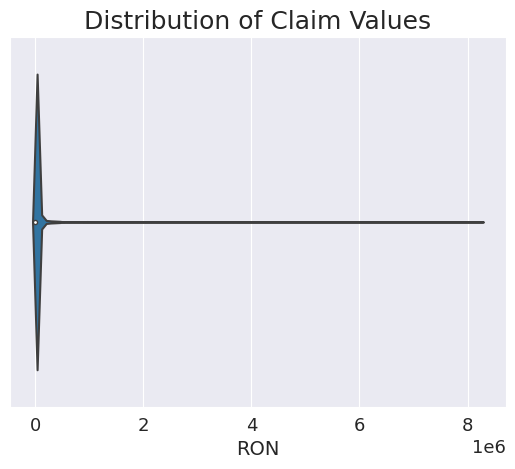

In [21]:
# look at the distribution of claim values
sns.violinplot(x= merged_pf.total_val)
plt.xlabel('RON')
plt.title('Distribution of Claim Values');

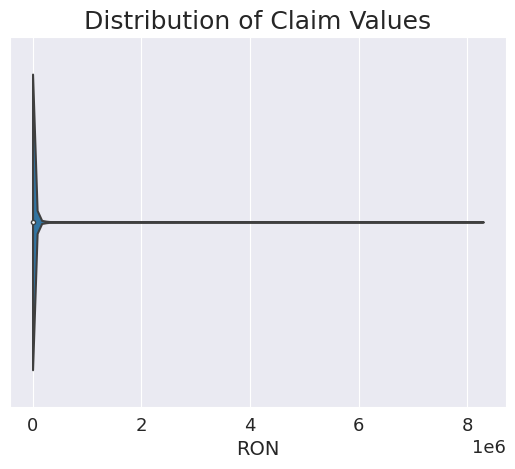

In [22]:
# just like with the frequency, as the vast majority of policies have no claims, it would be more helpful
# # to redo the distribution without those with no claims
# look at the distribution of claim values

sns.violinplot(x= merged_pf[merged_pf.total_val > 0].total_val)
plt.xlabel('RON')
plt.title('Distribution of Claim Values');

Both graphs highlight the extreme positive tail of the distribution, which suggests the existance of many outliers.

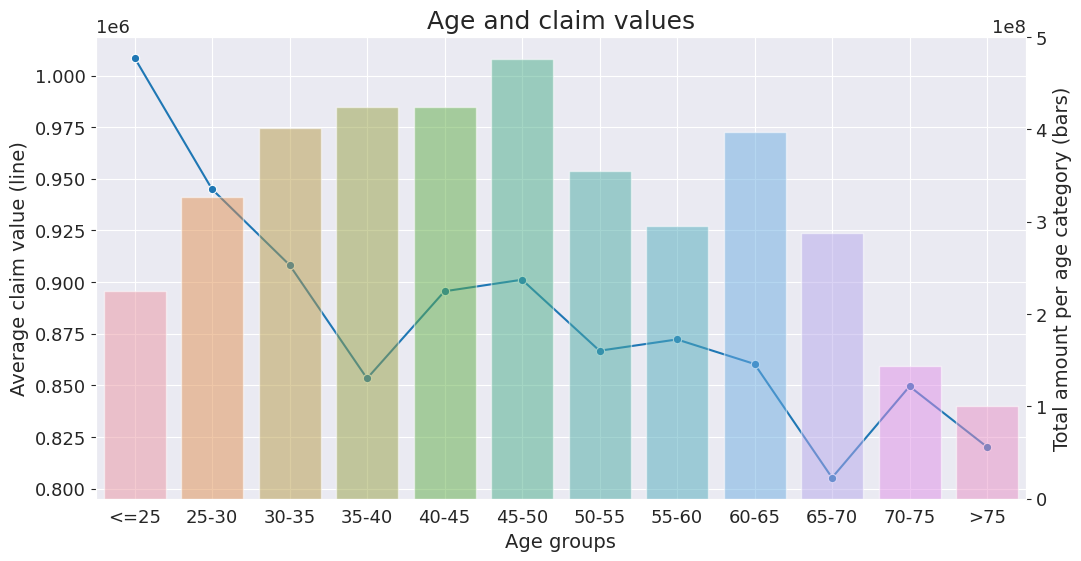

In [23]:
# plot the effect of age on claim value

ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

# for the lineplot, the events of each group category get summed up and divided by the sum of all exposures from that age group
sns.lineplot(data = [(merged_pf[merged_pf.age_cat == x].total_val.sum()/merged_pf[merged_pf.age_cat == x].total_ev.sum())*100
                    for x in ['<=25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', 
                    '70-75', '>75']], marker='o',  ax = ax1, sort = False)
ax2 = ax1.twinx()

sns.barplot(data = merged_pf, x='age_cat', y='total_val', estimator = 'sum', errorbar = None, alpha=0.5, ax = ax2)
ax2.grid(False)

ax1.set(ylabel='Average claim value (line)', xlabel='Age groups', title = 'Age and claim values')
ax2.set(ylabel = 'Total amount per age category (bars)');

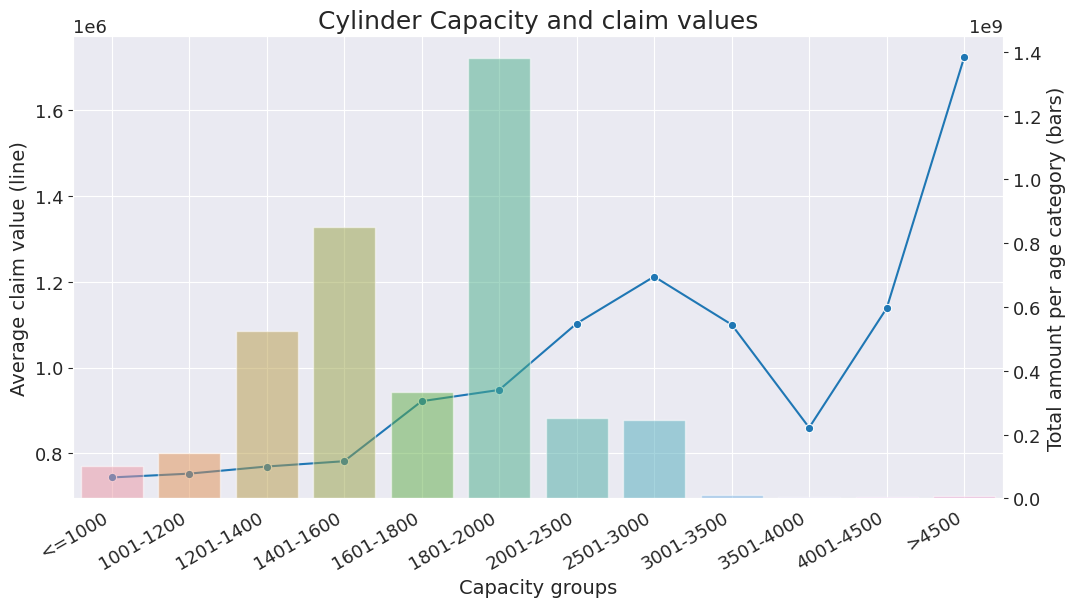

In [24]:
# plot the effect of cylinder capacity on the number of events

ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

# for the lineplot, the events of each group category get summed up and divided by the sum of all exposures from that age group
sns.lineplot(data = [(merged_pf[merged_pf.cap_cat == x].total_val.sum()/merged_pf[merged_pf.cap_cat == x].total_ev.sum())*100
                    for x in ['<=1000', '1001-1200', '1201-1400', '1401-1600', '1601-1800', '1801-2000', '2001-2500', 
                    '2501-3000', '3001-3500', '3501-4000', '4001-4500', '>4500']], marker='o',  ax = ax1, sort = False)
ax2 = ax1.twinx()

sns.barplot(data = merged_pf, x='cap_cat', y='total_val', estimator = 'sum', errorbar = None, alpha=0.5, ax = ax2)
ax2.grid(False)

ax1.set(ylabel='Average claim value (line)', xlabel='Capacity groups', title = 'Cylinder Capacity and claim values')
ax2.set(ylabel = 'Total amount per age category (bars)')

plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right');

In [25]:
print(f'Frequency of policies with 0 events: {merged_pf.query("total_ev == 0").shape[0]/merged_pf.shape[0]}')


Frequency of policies with 0 events: 0.9785795441022536


## Conclusions:

1. The vast majority of policies have no events, about 97.8%, which means that both frequency and severity distributions are 0 heavy!
2. Frequency less so, but severity has an extreme positive tail, suggesting the existence of many outliers.
3. Accident frequency is noticeably higher for the under 25s at about 10%. For the cylinder capacity, the 2500-3000 group has he highest at ~ 8%, though higher capacity groups remain at a relatively similar frequency.
4. Lowest frequency is found in the 60-65 group, with ~ 4.7%, and at <1000 cc, with 4.2%.
5. Highest average severity, of ~ 100k RON, is found at under 25s. For cylinder capacity, there is a noticeable jump to ~ 100k for 2500-3000 cc, then a dip to 70k for 3500-4000 cc, then continues to increase to 120k for >4500 cc.
6. Lowest severity for 65-70 and for < 1000 cc.


ALTERNATIVE METHOD OF PREPARING THE DATA FOR THE EDA

Using groupby and aggregate function:

In [29]:
agg = merged_pf.groupby(['age_cat', 'cap_cat']).agg(
    {
        'total_val': 'sum', 
        'total_ev': 'sum',
        'total_exp': 'sum',
        'idPolita': 'count',
        }
    ).assign(
        avg_freq = (agg.total_ev/agg.total_exp)*100,
        avg_sev = agg.total_val/agg.idPolita
        )
agg.head()

total_val  total_ev     total_exp  idPolita   avg_freq  \
age_cat cap_cat                                                                
<=25    <=1000     4.527286e+06     608.0   6996.711914     23012   8.689796   
        1001-1200  8.176569e+06     970.0  10050.124023     32295   9.651622   
        1201-1400  3.289754e+07    4055.0  41753.820312    142624   9.711686   
        1401-1600  4.406060e+07    5027.0  49989.140625    195715  10.056184   
        1601-1800  1.847938e+07    1443.0  14884.052734     67151   9.694940   

                      avg_sev  
age_cat cap_cat                
<=25    <=1000     196.735878  
        1001-1200  253.183736  
        1201-1400  230.659229  
        1401-1600  225.126321  
        1601-1800  275.191437

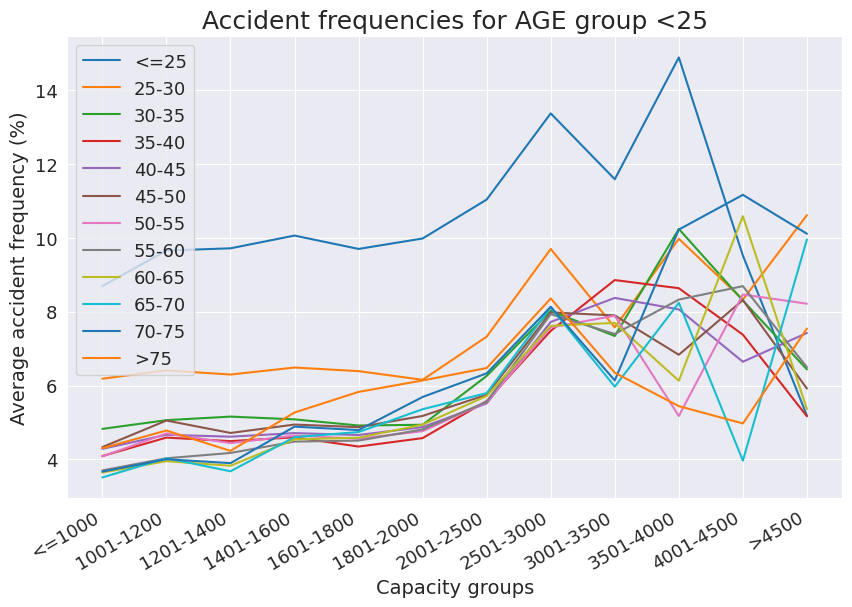

In [42]:
# example of lineplot created using the aggregated table
fig, ax = plt.subplots(figsize=(10,6))

ax= sns.lineplot(data=agg.loc[('<=25'), :].avg_freq, label = '<=25')
ax1 = sns.lineplot( data=agg.loc[('25-30'), :].avg_freq, label = '25-30')
ax1 = sns.lineplot( data=agg.loc[('30-35'), :].avg_freq, label = '30-35')
ax1 = sns.lineplot( data=agg.loc[('35-40'), :].avg_freq, label = '35-40')
ax1 = sns.lineplot( data=agg.loc[('40-45'), :].avg_freq, label = '40-45')
ax1 = sns.lineplot( data=agg.loc[('45-50'), :].avg_freq, label = '45-50')
ax1 = sns.lineplot( data=agg.loc[('50-55'), :].avg_freq, label = '50-55')
ax1 = sns.lineplot( data=agg.loc[('55-60'), :].avg_freq, label = '55-60')
ax1 = sns.lineplot( data=agg.loc[('60-65'), :].avg_freq, label = '60-65')
ax1 = sns.lineplot( data=agg.loc[('65-70'), :].avg_freq, label = '65-70')
ax1 = sns.lineplot( data=agg.loc[('70-75'), :].avg_freq, label = '70-75')
ax1 = sns.lineplot( data=agg.loc[('>75'), :].avg_freq, label = '>75')

ax1.set(ylabel='Average accident frequency (%)', xlabel='Capacity groups', title = 'Accident frequencies for AGE group <25')
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right');